The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, I will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use Pandas to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

In [1]:
# Import libraries

import pandas as pd
import numpy as np

In [2]:
loans = pd.read_csv('lending-club-data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
loans.shape

(122607, 68)

## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Frequency')

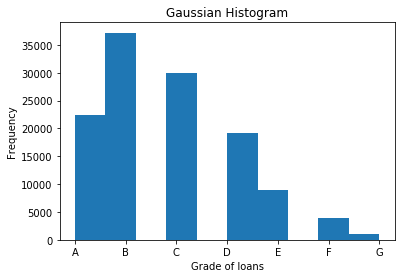

In [6]:
plt.hist(loans['grade'].values)
plt.title("Gaussian Histogram")
plt.xlabel("Grade of loans")
plt.ylabel("Frequency")

#plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `sub_grade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

Text(0,0.5,'Frequency')

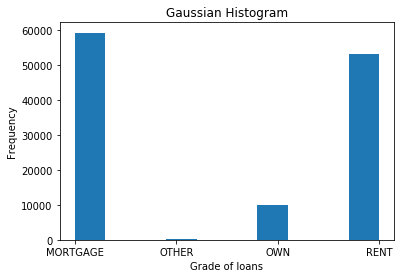

In [7]:
plt.hist(loans['home_ownership'].values)
plt.title("Gaussian Histogram")
plt.xlabel("Grade of loans")
plt.ylabel("Frequency")

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

Text(0,0.5,'Frequency')

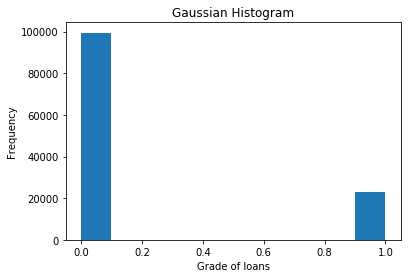

In [8]:
plt.hist(loans['bad_loans'].values)
plt.title("Gaussian Histogram")
plt.xlabel("Grade of loans")
plt.ylabel("Frequency")

In [9]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
#loans = loans.remove_column('bad_loans')

Text(0,0.5,'Frequency')

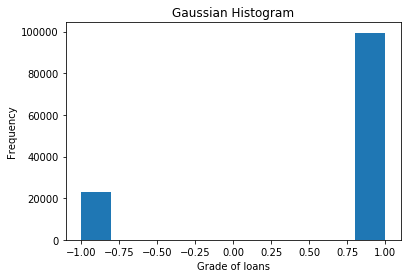

In [10]:
plt.hist(loans['safe_loans'].values)
plt.title("Gaussian Histogram")
plt.xlabel("Grade of loans")
plt.ylabel("Frequency")

In [11]:
loans.drop(['bad_loans'], axis = 1)
loans.shape

(122607, 69)

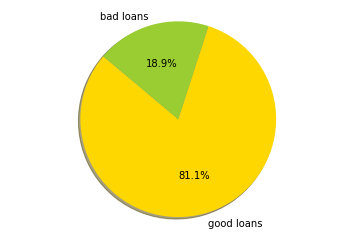

In [12]:
# Data to plot
labels = 'good loans', 'bad loans'
sizes = [100* (loans['safe_loans'].values==1).sum()/len(loans), (1 - (loans['safe_loans'].values==1).sum()/len(loans))*100]
colors = ['gold', 'yellowgreen']
explode = (0, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Features for the classification algorithm

we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [13]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [14]:
loans.shape

(122607, 13)

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [15]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print ("Number of safe loans  : %s" % len(safe_loans_raw))
print ("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [16]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(int(percentage*len(safe_loans_raw)), random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

In [36]:
print(loans_data.shape)
print(risky_loans.shape)


(46300, 13)
(23150, 13)


Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [17]:
print ("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print ("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print ("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


In [18]:
import json
with open('train-idx.json', 'r') as f:
    train_idx = json.load(f)
with open('validation-idx.json', 'r') as f:
    validation_idx = json.load(f)

In [19]:
print(len(train_idx))
print(len(validation_idx))
print(len(train_idx) + len(validation_idx))

37224
9284
46508


In [20]:
loans.values[0]

array(['B', 'B2', 0, 11, 'RENT', 27.65, 'credit_card', ' 36 months', 1, 1,
       83.7, 0.0, 1], dtype=object)

# Encoding category data

In [132]:

train_data.shape
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
loans_object = loans.select_dtypes(include=[object])
#onehotencoder = OneHotEncoder(categorical_features = ['grade'])
#train_data = onehotencoder.fit_transform(train_data).toarray()
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
loans_object = loans_object.apply(le.fit_transform)
loans_object.head()

,grade,sub_grade,home_ownership,purpose,term
0,1,6,3,1,0
1,2,13,3,0,1
2,2,14,3,9,0
3,2,10,3,8,0
4,0,3,3,11,0


In [133]:
onehotencoder = OneHotEncoder()
loans_object = onehotencoder.fit_transform(loans_object).toarray()

In [134]:
loans_left = loans.select_dtypes(exclude=[object])
loans_transform =  pd.concat([loans_left, pd.DataFrame(loans_object)], axis=1,join='inner') 

In [135]:
loans_transform.shape

(122607, 68)

In [137]:
loans_transform.head(1)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,0,1,...,50,51,52,53,54,55,56,57,58,59
0,0,11,27.65,1,1,83.7,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [140]:
# Reprocess the train and validation data sets
train_data = loans_transform.iloc[train_idx]
validation_data = loans_transform.iloc[validation_idx]

# Use decision tree to build a classifier

Now, let's use the built-in decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above. Use `validation_set=None` to get the same results as everyone else.

In [141]:
safe_loans_raw = train_data[train_data[target] == +1]
risky_loans_raw = train_data[train_data[target] == -1]
print ("Number of safe loans  : %s" % len(safe_loans_raw))
print ("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 18748
Number of risky loans : 18476


In [142]:
#train_data.columns = features + [target]
train_data.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,0,1,...,50,51,52,53,54,55,56,57,58,59
1,1,1,1.00,1,1,9.4,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,5,5.55,1,1,32.6,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [143]:
#import re
#import string

#train_data['term'] = train_data['term'].apply(lambda x: re.findall(r'\d+', str(x)))
#import numpy as np
#train_data['term'] = train_data['term'].apply(lambda x : x[0])
#train_data['term'] = train_data['term'].astype(int)
# train_data.dtypes

In [68]:
# Check if there is missing data

train_data.isnull().sum(axis=0)

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
safe_loans               0
dtype: int64

In [69]:
validation_data.isnull().sum(axis=0)

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
safe_loans               0
dtype: int64

In [70]:
# Taking care of missing data
#from sklearn.preprocessing import Imputer
#imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
#imputer.fit(train_data)
#train_data = imputer(train_data)

(37224, 13)

# Use decision tree to build a classifier

Create decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above. Use `validation_set=None` to get the same results as everyone else.

In [145]:
train_data.shape

(37224, 68)

In [151]:
X_train = train_data.drop(['safe_loans'], axis = 1)
Y_train = train_data['safe_loans']

# change validation set
X_valid = validation_data.drop(['safe_loans'], axis = 1)
Y_valid = validation_data['safe_loans']

In [147]:
X_train.shape

(37224, 67)

In [175]:
X_train.head(0)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,0,1,2,...,50,51,52,53,54,55,56,57,58,59


In [158]:
from sklearn import tree
decision_tree_model= tree.DecisionTreeClassifier(max_depth = 6)

In [159]:
decision_tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [160]:
train_prediction = decision_tree_model.predict(X_train)

In [161]:
train_accuracy = (train_prediction == Y_train).sum()/len(Y_train)
print(train_accuracy)

0.640527616591


In [197]:
valid_prediction = decision_tree_model.predict(X_valid)
valid_accuracy = (valid_prediction == Y_valid).sum()/len(Y_valid)
print(valid_accuracy)

0.636363636364


## Let us assume that each mistake costs money:

* Assume a cost of `$10,000` per false negative.
* Assume a cost of `$20,000` per false positive.

What is the total cost of mistakes made by decicion model

In [206]:
print(valid_prediction.shape)
print(Y_valid.shape)

(9284,)
(9284,)


In [211]:
false_positive= ((valid_prediction != Y_valid) & (valid_prediction==1)).sum()
print(false_positive)

1661


In [213]:
false_negative= ((valid_prediction != Y_valid) & (valid_prediction==-1)).sum()
print(false_negative)

print(false_negative * 10000 + false_positive*20000)

1715
50370000


In [163]:
# small depth 
small_tree_model= tree.DecisionTreeClassifier(max_depth = 2)

In [164]:
small_tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [165]:
small_train_prediction = small_tree_model.predict(X_train)
small_train_accuracy = (small_train_prediction == Y_train).sum()/len(Y_train)
print(small_train_accuracy)

0.613502041694


In [166]:
small_valid_prediction = small_tree_model.predict(X_valid)
small_valid_accuracy = (small_valid_prediction == Y_valid).sum()/len(Y_valid)
print(small_valid_accuracy)

0.619345109866


In [172]:
import graphviz

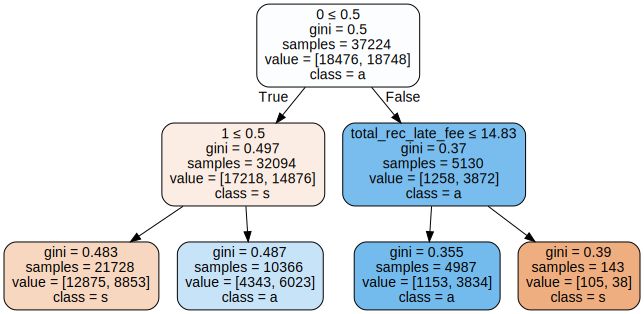

In [180]:
#tree.export_graphviz(decision_tree_model,
#   out_file='tree.dot') 
dot_data = tree.export_graphviz(small_tree_model, out_file=None, 
                         feature_names=X_train.columns.tolist(),  
                         class_names='safe_loans',
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [195]:
big_model= tree.DecisionTreeClassifier(max_depth = 10)
big_model.fit(X_train, Y_train)

big_train_prediction = big_model.predict(X_train)
big_train_accuracy = (big_train_prediction == Y_train).sum()/len(Y_train)
print(big_train_accuracy)

big_valid_prediction = big_model.predict(X_valid)
big_valid_accuracy = (big_valid_prediction == Y_valid).sum()/len(Y_valid)
print(big_valid_accuracy)

0.66379217709
0.626130978027


# Sample validation data accuracy 

In [214]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)


In [215]:
X_sample_validation_data.shape

(4, 67)

In [219]:
sample_validation_data.shape
X_sample_validation_data = sample_validation_data.drop(['safe_loans'], axis = 1)
Y_sample_validation_data = sample_validation_data['safe_loans']
Y_sample_prediction = decision_tree_model.predict(X_sample_validation_data)

print(Y_sample_prediction)

print(' ')
print(Y_sample_validation_data)

print(Y_sample_prediction == Y_sample_validation_data)

print(decision_tree_model.predict_proba(X_sample_validation_data))

[ 1 -1 -1  1]
 
19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64
19     True
79    False
24     True
41    False
Name: safe_loans, dtype: bool
[[ 0.34156543  0.65843457]
 [ 0.53630646  0.46369354]
 [ 0.64750958  0.35249042]
 [ 0.20789474  0.79210526]]


In [194]:
# Visualization of sample_validation_data
X_sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,0,1,2,...,50,51,52,53,54,55,56,57,58,59
19,0,11,11.18,1,1,82.4,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79,0,10,16.85,1,1,96.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,3,13.97,0,1,59.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41,0,11,16.33,1,1,62.1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
